In [71]:
import networkx as nx
import numpy as np
import copy as cp

### Question 3

I chose to implement Google's PageRank centrality measure. 

All code is my own. I used https://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html as a reference.

In [2]:
'''
Inputs
------
G: Networkx graph
n: node for which to compute connectivity (if None, compute for all nodes), default: None
p: damping factor (p in range (0,1)), default: 0.15
max_iter: how many iterations before returning connectivity, default: 100

Outputs
-------
connectivity_dict: dictionary of nodes -> connectivity 
'''
def my_pagerank(G, n=None, p=0.15, max_iter=100):

    # if G is an undirected graph, convert it to a directed graph with 2 directed edges for each undirected edge
    if not nx.is_directed(G):
        G = G.to_directed()

    order = G.order()

    # create vector connectivity - initialize connectivities to all be the same (normalized {0, 1})
    connectivity = np.full((order,1), 1/order) 

    # create matrix A - transition matrix showing importance that each node gives to other nodes
    A = np.zeros((order, order))
    for node1 in range(order):
        for node2 in range(order):
            if node1 in list(G.neighbors(node2)):
                deg = G.out_degree[node2]
                A[node1][node2] = 1 / deg

    # create matrix B - initialized to initial connectivities
    B = np.full((order, order), 1 / order)
    
    # create matrix PR(A) - add in random "surfing" between nodes
    PRA = (1 - p) * A + p * B

    # multiply connectivities by PR(A) until convergence
    for i in range(max_iter):
        old_connectivity = cp.deepcopy(connectivity)
        connectivity = np.matmul(PRA, connectivity)

        # if we converge (to 6 decimal places), stop iterating
        if np.array_equal(np.around(connectivity, decimals=6), np.around(old_connectivity, decimals=6)):
            break
        
    # print(connectivity)
    connectivity_dict = {}
    for i, c in zip(range(order), connectivity):
        connectivity_dict[i] = c[0]

    return connectivity_dict
    

#### Error handling

My function handles cases where:
    - 
    -
    -
    -

In [ ]:
'''
Comparing my implementation
'''

### Question 4



In [43]:
from bs4 import BeautifulSoup
import requests
import networkx as nx

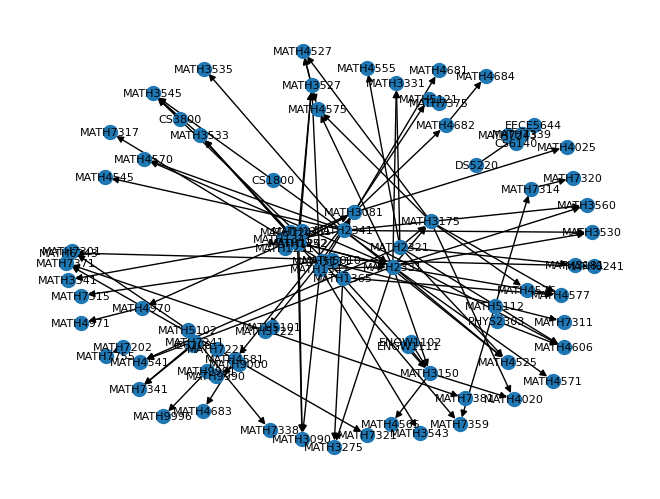

In [53]:
def get_dept_codes() -> list[str]:
    codes = []
    
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    catalog_soup = BeautifulSoup(catalog_html)

    atoz_soup = catalog_soup.find('div', id='atozindex')
    dept_lists_soup = atoz_soup.find_all('ul')
    for l in dept_lists_soup:
        depts_soup = l.find_all('li')
        for li in depts_soup:
            codes.append(li.a.get('href').split('/')[-2])
            
    return codes

def dept_code_to_url(dept_code: str) -> str:
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    catalog_soup = BeautifulSoup(catalog_html)
    
    url = '/course-descriptions/' + dept_code + '/'
    if url in [x['href'] for x in catalog_soup.find_all('a', href=True)]:
        return 'https://catalog.northeastern.edu' + url
                
    raise ValueError('No department found with the code ' + dept_code)
            

def get_prereqs(department_code: str) -> list:
    try:
        href = dept_code_to_url(department_code)
    except ValueError as e:
        return []
    
    dept_res = requests.get(href)
    dept_html = dept_res.text
    dept_soup = BeautifulSoup(dept_html)

    courses_to_prereqs = {}

    course_descs_soup = dept_soup.find('div', attrs={'class' : 'sc_sccoursedescs'})
    
    for course in course_descs_soup.find_all('div', attrs={'class' : 'courseblock'}):
        course_code = course.find('p', attrs={'class' : 'courseblocktitle'}).text.split('.')[0].replace(u'\xa0', '')
        prereqs = []
        for extra in course.find_all('p', attrs={'class' : 'courseblockextra'}):
            if 'Prerequisite(s)' in extra.text:
                for link in extra.find_all('a', href=True):
                    prereqs.append(link.text.replace(u'\xa0', ''))
        courses_to_prereqs[course_code] = prereqs

    return courses_to_prereqs

def course_prereqs(courses_to_prereqs: dict):
    G = nx.DiGraph()
    for k,v in courses_to_prereqs.items():
        edges = [(val,k) for val in v]
        G.add_edges_from(edges)

    nx.draw(G, node_size=100, with_labels=True, font_size=8)
    return G
    
course_prereqs(get_prereqs('math'))
